# 17-6. 프로젝트 - Movielens 영화 SBR

Movielens 1M Dataset을 기반으로, Session based Recommendation 시스템을 제작해 보겠습니다.

데이터는 아래와 같이 정리합니다. 


``` python 
# 1) wget으로 데이터 다운로드
$ wget http://files.grouplens.org/datasets/movielens/ml-1m.zip

# 2) 다운받은 데이터를 작업디렉토리로 이동
$ mv ml-1m.zip ~/aiffel/yoochoose-data

# 3) 압축 해제
$ cd ~/aiffel/yoochoose-data && unzip ml-1m.zip
```

평가 기준에 대해서는 아래 글을 참고합니다.

[추천시스템에 사용되는 metrics 정리](https://zzaebok.github.io/recommender_system/metrics/rec_metrics/)

In [1]:
import datetime as dt
from pathlib import Path
import os
import matplotlib as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [65]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [3]:
pd.set_option('display.max_row', 500)

In [55]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose-data/ml-1m') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data


,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [56]:
data['Datetime'] = '1970-01-01 00:00:00'
data['Datetime'] = pd.to_datetime(data['Datetime'], format="%Y-%m-%d %H:%M:%S")
data.Datetime = data.Datetime + data.Time.map(lambda x : dt.timedelta(seconds=x))

In [57]:
data

,UserId,ItemId,Rating,Time,Datetime
31,1,3186,4,978300019,2000-12-31 22:00:19
22,1,1270,5,978300055,2000-12-31 22:00:55
27,1,1721,4,978300055,2000-12-31 22:00:55
37,1,1022,5,978300055,2000-12-31 22:00:55
24,1,2340,3,978300103,2000-12-31 22:01:43
...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10 14:40:29
999988,6040,1921,4,997454464,2001-08-10 14:41:04
1000172,6040,1784,3,997454464,2001-08-10 14:41:04
1000167,6040,161,3,997454486,2001-08-10 14:41:26


In [5]:
# data.Time = pd.to_datetime(data.Time, dayfirst = "1970-01-01", unit = 's')

In [6]:
# data.Time

31        2000-12-31 22:00:19
22        2000-12-31 22:00:55
27        2000-12-31 22:00:55
37        2000-12-31 22:00:55
24        2000-12-31 22:01:43
                  ...        
1000019   2001-08-10 14:40:29
999988    2001-08-10 14:41:04
1000172   2001-08-10 14:41:04
1000167   2001-08-10 14:41:26
1000042   2001-08-20 13:44:15
Name: Time, Length: 1000209, dtype: datetime64[ns]

## Step 1. 데이터 EDA, 전처리 
위와 같이 간단히 구성해 본 데이터셋을 꼼꼼이 살펴보면서 항목별 기본분석, session length, session time, cleaning 등의 작업을 진행합니다.
특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.

In [58]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

총 6040명의 유저들이 3706개의 영화를 평가한것을 확인할 수 있습니다.                 


In [59]:
data.groupby('UserId').size()

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

유저별로 얼마나 활동했는지 정리해보도록 하겠습니다.

In [60]:
data.groupby('UserId').size().mean() , data.groupby('UserId').size().median()

(165.5975165562914, 96.0)

유저별로 평균 165개의 영화를 보았습니다. 중앙값은 96입니다. 아무래도 HEAVY 유저들때문에 평균값이 더 치우진 결과를 만든 것 같네요

In [61]:
data.groupby('UserId').size().min(), data.groupby('UserId').size().max()

(20, 2314)

가장 적은 영화를 본 유저는 20편, 가장 많은 영화를 본사람은 2314편이나 봤습니다.

In [62]:
data.groupby('UserId').size().quantile(0.90)

400.0

상위 10%의 영화를 본사람들이 400편 정도를 봤네요. 

<AxesSubplot:>

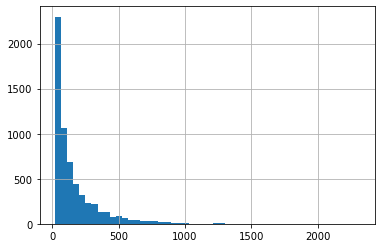

In [63]:
data.groupby('UserId').size().hist(bins = 50)

히스토그램으로 보면 아래와 같습니다.
좀 더 자세히 보기위해 matplotlib의 hist를 사용하겠습니다.

(array([2.298e+03, 1.063e+03, 6.880e+02, 4.420e+02, 3.240e+02, 2.330e+02,
        2.170e+02, 1.290e+02, 1.320e+02, 8.000e+01, 8.400e+01, 6.500e+01,
        4.400e+01, 3.700e+01, 3.400e+01, 3.200e+01, 2.600e+01, 2.300e+01,
        2.300e+01, 1.200e+01, 1.100e+01, 1.100e+01, 3.000e+00, 2.000e+00,
        3.000e+00, 3.000e+00, 8.000e+00, 5.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([  20.  ,   65.88,  111.76,  157.64,  203.52,  249.4 ,  295.28,
         341.16,  387.04,  432.92,  478.8 ,  524.68,  570.56,  616.44,
         662.32,  708.2 ,  754.08,  799.96,  845.84,  891.72,  937.6 ,
         983.48, 1029.36, 1075.24, 1121.12, 1167.  , 1212.88, 1258.76,
        1304.64, 1350.52, 1396.4 , 1442.28, 1488.16, 1534.04, 1579.92,
        1625.8 , 1671

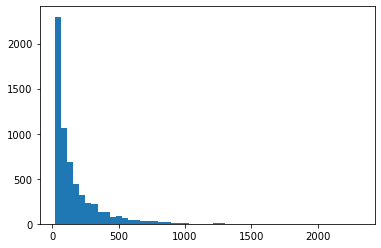

In [67]:
plt.hist(data.groupby('UserId').size().values.tolist(), bins = 50)

2.298e+03 + 1.063e+03 = 3361, 3361명의 사람이 111번만큼의 영화를 봤습니다.              
즉 절반 넘는 숫자가 111번 보다 미만으로 봤다고 볼 수 있습니다. 

<AxesSubplot:>

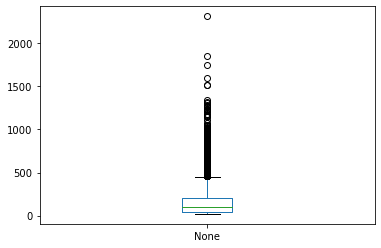

In [68]:
data.groupby('UserId').size().plot.box()

AxesSubplot(0.125,0.125;0.775x0.755)


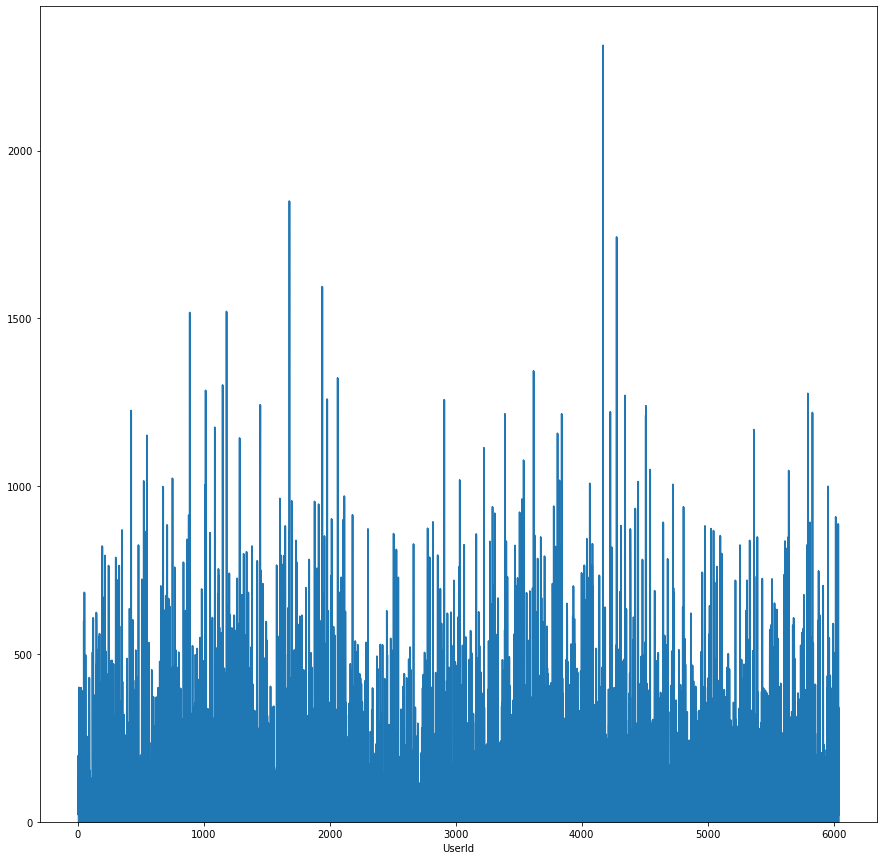

In [69]:
print(data.groupby('UserId').size().plot.area(figsize = (15,15)))

id에 따라서는 이렇게 되군요. 한번 2000편 이상, 정확히 2314번 본 유저에 대해서 살펴보도록 하겠습니다.

In [70]:
movie_2314 = data.groupby('UserId').size()[data.groupby('UserId').size() == 2314].index[0]

In [71]:
movie_2314

4169

In [72]:
movie_2314 = data[data['UserId'] == 4169]

In [73]:
movie_2314.head(100)

,UserId,ItemId,Rating,Time,Datetime
696969,4169,1268,5,965333392,2000-08-03 20:09:52
697168,4169,2617,4,965333392,2000-08-03 20:09:52
697185,4169,2628,4,965333392,2000-08-03 20:09:52
697219,4169,2653,4,965333392,2000-08-03 20:09:52
697275,4169,423,3,965333392,2000-08-03 20:09:52
696168,4169,3801,5,965333481,2000-08-03 20:11:21
696250,4169,3841,2,965333481,2000-08-03 20:11:21
697903,4169,3761,3,965333481,2000-08-03 20:11:21
697954,4169,3788,3,965333481,2000-08-03 20:11:21
695653,4169,3794,4,965333519,2000-08-03 20:11:59


In [74]:
movie_2314.tail(100)

,UserId,ItemId,Rating,Time,Datetime
696438,4169,3145,4,985827965,2001-03-29 01:06:05
697753,4169,2763,4,985828120,2001-03-29 01:08:40
696069,4169,252,4,985828138,2001-03-29 01:08:58
697096,4169,2280,3,985828222,2001-03-29 01:10:22
696377,4169,2166,4,985828278,2001-03-29 01:11:18
697415,4169,1367,4,985828480,2001-03-29 01:14:40
697444,4169,2327,3,985828700,2001-03-29 01:18:20
696790,4169,3598,3,988322660,2001-04-26 22:04:20
696225,4169,2889,4,988323821,2001-04-26 22:23:41
696616,4169,2590,2,988323882,2001-04-26 22:24:42


대다수 유저들은 적은수의 평가를 했으며 500편 이상의 영화를 본 유저들은 극히 드물다는것을 확인했습니다.

In [75]:
length_per_user = data.groupby('UserId').size()
length_per_user 

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [76]:
length_count = length_per_user.groupby(length_per_user).size() #value값을 가지는 cout를 나타낸다. 

In [77]:
length_count

20      86
21      91
22      77
23      81
24      81
        ..
1521     1
1595     1
1743     1
1850     1
2314     1
Length: 743, dtype: int64

In [78]:
length_percent_cumsum =  length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

In [79]:
length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

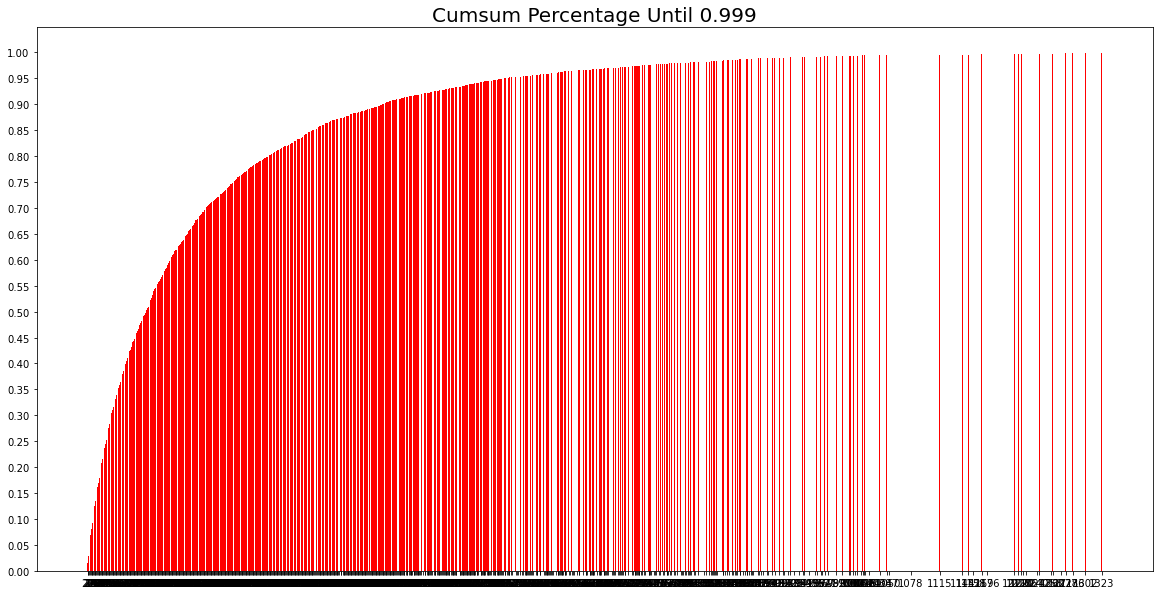

In [80]:
import matplotlib.pyplot as plt
plt.figure(figsize = (20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

이 유저들을 세션단위로 예측하려면 시간순으로 정리하는 것이 적당하다고 생각합니다.

In [81]:
data.sort_values(['UserId','Time'])

,UserId,ItemId,Rating,Time,Datetime
31,1,3186,4,978300019,2000-12-31 22:00:19
22,1,1270,5,978300055,2000-12-31 22:00:55
27,1,1721,4,978300055,2000-12-31 22:00:55
37,1,1022,5,978300055,2000-12-31 22:00:55
24,1,2340,3,978300103,2000-12-31 22:01:43
...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10 14:40:29
999988,6040,1921,4,997454464,2001-08-10 14:41:04
1000172,6040,1784,3,997454464,2001-08-10 14:41:04
1000167,6040,161,3,997454486,2001-08-10 14:41:26


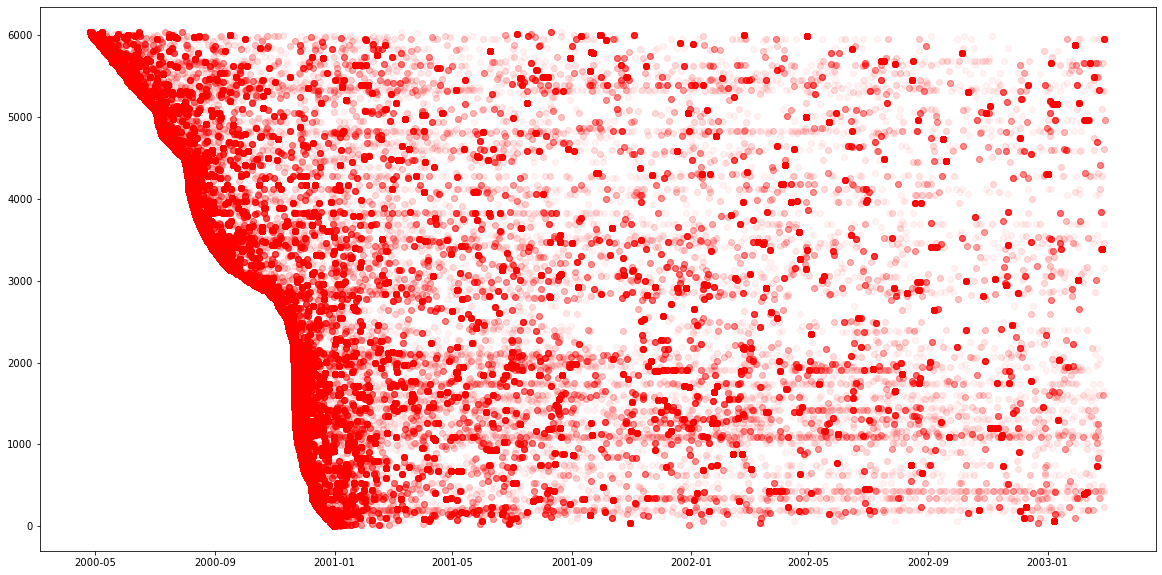

In [83]:
plt.figure(figsize=(20, 10))
plt.scatter(x=data.Datetime,
           y=data.UserId,
           color='red', alpha = 0.05)
# plt.xticks(data.Datetime.values, fontsize=15)
# data.plot(kind='scatter', x='Datetime', y='UserId', color='blue')
plt.show()

유저 id와 시간대를 scatter plot으로 표현하면 위와 같습니다.  
추측해본 사실은 아래와 같습니다. 

1. 아무래도 유저들은 id 생성 초반에 많은 활동을 하는 편입니다.

2. 그리고 다수의 유저는 초반 활동 이후 활동을 잘 하지않습니다.

3. 하지만 꾸준하게 활동을 하는 유저도 분명 존재합니다.

## Data Cleaning 

유저가 최소 1개 이상 클릭했을 때 다음 클릭을 예측하는 것이므로, 길이 1인 세션은 제거합니다.
너무 적게 클릭된 아이템 역시 이상한 아이템일 가능성이 있으므로, 제거합니다.


평점을 3 이하로 준 영화는 실망스러운 영화였음으로 데이터에서 제외할수도있을것같습니다. 하지만 일단 그대로 진행하도록 하겠습니다.

In [84]:
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data
def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data

def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data


# SessionId -> UserId로 변경
def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data

In [91]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,ItemId,Rating,Time,Datetime
1000138,6040,858,4,956703932,2000-04-25 23:05:32
999873,6040,593,5,956703954,2000-04-25 23:05:54
1000153,6040,2384,4,956703954,2000-04-25 23:05:54
1000007,6040,1961,4,956703977,2000-04-25 23:06:17
1000192,6040,2019,5,956703977,2000-04-25 23:06:17
...,...,...,...,...,...
825793,4958,2399,1,1046454338,2003-02-28 17:45:38
825438,4958,1407,5,1046454443,2003-02-28 17:47:23
825724,4958,3264,4,1046454548,2003-02-28 17:49:08
825731,4958,2634,3,1046454548,2003-02-28 17:49:08


In [40]:
# SessionId -> UserId로 변경
'''
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('UserId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

# train / valid / test split
data_train, data_test = split_by_date(data, n_days=1)
data_train, data_val = split_by_date(data_train, n_days=1)
'''

"\ndef split_by_date(data: pd.DataFrame, n_days: int):\n    final_time = data['Time'].max()\n    session_last_time = data.groupby('UserId')['Time'].max()\n    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index\n    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index\n\n    before_date = data[data['UserId'].isin(session_in_train)]\n    after_date = data[data['UserId'].isin(session_in_test)]\n    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]\n    return before_date, after_date\n\n# train / valid / test split\ndata_train, data_test = split_by_date(data, n_days=1)\ndata_train, data_val = split_by_date(data_train, n_days=1)\n"

In [88]:
data.sort_values(by=['Time'], inplace=True) # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html
data.shape

(999611, 5)

In [89]:
data.head()

,UserId,ItemId,Rating,Time,Datetime
1000138,6040,858,4,956703932,2000-04-25 23:05:32
999873,6040,593,5,956703954,2000-04-25 23:05:54
1000153,6040,2384,4,956703954,2000-04-25 23:05:54
1000007,6040,1961,4,956703977,2000-04-25 23:06:17
1000192,6040,2019,5,956703977,2000-04-25 23:06:17


In [90]:
data.tail()

,UserId,ItemId,Rating,Time,Datetime
825793,4958,2399,1,1046454338,2003-02-28 17:45:38
825438,4958,1407,5,1046454443,2003-02-28 17:47:23
825724,4958,3264,4,1046454548,2003-02-28 17:49:08
825731,4958,2634,3,1046454548,2003-02-28 17:49:08
825603,4958,1924,4,1046454590,2003-02-28 17:49:50


## data split

In [92]:
origin_data = data.copy()

In [94]:
data['Datetime'].max() - data['Datetime'].min()

Timedelta('1038 days 18:44:18')

In [95]:
latest = data['Datetime'].max()

In [96]:
test_days = latest - dt.timedelta(15)
test_days

Timestamp('2003-02-13 17:49:50')

In [97]:
valid_days = test_days - dt.timedelta(90)
valid_days

Timestamp('2002-11-15 17:49:50')

In [98]:
train_data = data[data['Datetime'] <= valid_days]
test_data = data[data['Datetime'] > test_days]

temp_data = data[data['Datetime'] <= test_days]
valid_data = temp_data[temp_data['Datetime'] > valid_days]

In [99]:
train_data['Datetime'].min(), train_data['Datetime'].max()

(Timestamp('2000-04-25 23:05:32'), Timestamp('2002-11-15 16:08:13'))

In [100]:
valid_data['Datetime'].min(), valid_data['Datetime'].max()

(Timestamp('2002-11-15 20:19:05'), Timestamp('2003-02-13 16:36:54'))

In [101]:
test_data['Datetime'].min(), test_data['Datetime'].max()

(Timestamp('2003-02-13 18:06:30'), Timestamp('2003-02-28 17:49:50'))

In [102]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Datetime"].min()}\n'
          f'\t Last Time : {data["Datetime"].max()}\n')

In [103]:
stats_info(train_data, 'train')
stats_info(valid_data, 'valid')
stats_info(test_data, 'test')

* train Set Stats Info
	 Events: 994167
	 Sessions: 6039
	 Items: 3416
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-11-15 16:08:13

* valid Set Stats Info
	 Events: 4787
	 Sessions: 243
	 Items: 1813
	 First Time : 2002-11-15 20:19:05
	 Last Time : 2003-02-13 16:36:54

* test Set Stats Info
	 Events: 657
	 Sessions: 68
	 Items: 538
	 First Time : 2003-02-13 18:06:30
	 Last Time : 2003-02-28 17:49:50



In [104]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(data_train['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

data_train = indexing(data_train, id2idx)
data_val = indexing(data_val, id2idx)
data_test = indexing(data_test, id2idx)

In [105]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

data_train.to_pickle(save_path / 'train.pkl')
data_val.to_pickle(save_path / 'valid.pkl')
data_test.to_pickle(save_path / 'test.pkl')

## Step 2. 미니 배치의 구성

실습코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.


단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.

In [114]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [111]:
# SessionId -> UserId로 변경
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [107]:
tr_dataset = SessionDataset(data_train)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
1000138,6040,858,4,2000-04-25 23:05:32,0
999873,6040,593,5,2000-04-25 23:05:54,1
1000153,6040,2384,4,2000-04-25 23:05:54,2
1000007,6040,1961,4,2000-04-25 23:06:17,3
1000192,6040,2019,5,2000-04-25 23:06:17,4
999868,6040,573,4,2000-04-25 23:07:36,5
999877,6040,1419,3,2000-04-25 23:07:36,6
999920,6040,213,5,2000-04-25 23:07:36,7
999967,6040,3111,5,2000-04-25 23:07:36,8
999980,6040,3505,4,2000-04-25 23:07:36,9


In [108]:
tr_dataset.click_offsets

array([     0,     76,    174, ..., 699559, 699682, 700000], dtype=int32)

In [112]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 4867, 4868, 4869])

In [115]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
1000138,6040,858,4,2000-04-25 23:05:32,0
999873,6040,593,5,2000-04-25 23:05:54,1
1000153,6040,2384,4,2000-04-25 23:05:54,2
1000007,6040,1961,4,2000-04-25 23:06:17,3
1000192,6040,2019,5,2000-04-25 23:06:17,4
999868,6040,573,4,2000-04-25 23:07:36,5
999877,6040,1419,3,2000-04-25 23:07:36,6
999920,6040,213,5,2000-04-25 23:07:36,7
999967,6040,3111,5,2000-04-25 23:07:36,8
999980,6040,3505,4,2000-04-25 23:07:36,9


In [116]:
iter_ex = iter(tr_data_loader)

## Step 3. 모델 구성

이 부분도 실습코드 내역을 참고하여 다양하게 모델 구조를 시도해볼 수 있습니다.

In [122]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [123]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [  1  77 172 205]
Label Item Idx are :       [  2  78 173 206]
Previous Masked Input Idx are []


In [124]:
# SessionId -> UserId로 변경
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(data_train, data_val, data_test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)

In [125]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(256, 1, 3408)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    519000    
_________________________________________________________________
dropout (Dropout)            (256, 50)                 0         
_________________________________________________________________
dense (Dense)                (256, 3408)               173808    
Total params: 692,808
Trainable params: 692,808
Non-trainable params: 0
_________________________________________________________________


## Step 4. 모델 학습
다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 합니다. 실습코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 합니다.

In [128]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [126]:
# SessionId -> UserId
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [129]:
train_model(model, args)

Train:   0%|          | 0/2715 [00:00<?, ?it/s, accuracy=0.0117, train_loss=6.75] 

	 - Recall@20 epoch 1: 0.140426
	 - MRR@20    epoch 1: 0.033401



Train:   0%|          | 0/2715 [00:00<?, ?it/s, accuracy=0.00391, train_loss=6.54]

	 - Recall@20 epoch 2: 0.170898
	 - MRR@20    epoch 2: 0.040408



Train:   0%|          | 0/2715 [00:00<?, ?it/s, accuracy=0, train_loss=6.46]      

	 - Recall@20 epoch 3: 0.181613
	 - MRR@20    epoch 3: 0.042982



Train:   0%|          | 0/2715 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.35] 

	 - Recall@20 epoch 4: 0.186469
	 - MRR@20    epoch 4: 0.044612



Evaluation:  74%|███████▍  | 432/580 [05:45<01:58,  1.25it/s]

	 - Recall@20 epoch 5: 0.190249
	 - MRR@20    epoch 5: 0.046062



## Step 5. 모델 테스트
미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.



In [131]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, data_test)

Evaluation:  80%|████████  | 464/578 [06:09<01:30,  1.25it/s]

	 - Recall@20: 0.188881
	 - MRR@20: 0.044112



### 조건 1
* learning rate를 높여본다. (0.01) https://bioinformaticsandme.tistory.com/130
* recall이 줄어든다. train_loss는 줄어들다가 늘어난다. 위 블로그의 그래프에서 'very high learning rate' 에 가까운 패턴이다.
* 테스트 결과도 기존 조건보다 근소하게 나쁜 결과를 보였다.

In [132]:
args2 = Args(data_train, data_val, data_test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.01, epochs=5, k=20)
model2 = create_model(args2)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(256, 1, 3408)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    519000    
_________________________________________________________________
dropout_1 (Dropout)          (256, 50)                 0         
_________________________________________________________________
dense_1 (Dense)              (256, 3408)               173808    
Total params: 692,808
Trainable params: 692,808
Non-trainable params: 0
_________________________________________________________________


In [133]:
train_model(model2, args2)

Train:   0%|          | 0/2715 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.54] 

	 - Recall@20 epoch 1: 0.180149
	 - MRR@20    epoch 1: 0.044979



Train:   0%|          | 0/2715 [00:00<?, ?it/s, accuracy=0.0195, train_loss=6.52] 

	 - Recall@20 epoch 2: 0.179272
	 - MRR@20    epoch 2: 0.046392



Train:   0%|          | 0/2715 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.48] 

	 - Recall@20 epoch 3: 0.174913
	 - MRR@20    epoch 3: 0.045600



Train:   0%|          | 0/2715 [00:00<?, ?it/s, accuracy=0.0195, train_loss=6.44] 

	 - Recall@20 epoch 4: 0.172282
	 - MRR@20    epoch 4: 0.045082



Evaluation:  74%|███████▍  | 432/580 [05:41<01:57,  1.26it/s]

	 - Recall@20 epoch 5: 0.168810
	 - MRR@20    epoch 5: 0.043977



In [134]:
test_model(model2, args2, data_test)

Evaluation:  80%|████████  | 464/578 [06:04<01:29,  1.27it/s]

	 - Recall@20: 0.164062
	 - MRR@20: 0.040402



### 조건 2
* learning rate를 낮춰본다. (0.0001)

결과가 폭망했다. 아무래도 epoch수가 적으니 러닝 rate를 낮추는건 좋은 선택이 아닌것같다.

In [135]:
args3 = Args(data_train, data_val, data_test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.0001, epochs=5, k=20)
model3 = create_model(args3)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(256, 1, 3408)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    519000    
_________________________________________________________________
dropout_2 (Dropout)          (256, 50)                 0         
_________________________________________________________________
dense_2 (Dense)              (256, 3408)               173808    
Total params: 692,808
Trainable params: 692,808
Non-trainable params: 0
_________________________________________________________________


In [136]:
train_model(model3, args3)

Train:   0%|          | 0/2715 [00:00<?, ?it/s, accuracy=0, train_loss=7.49]      

	 - Recall@20 epoch 1: 0.049524
	 - MRR@20    epoch 1: 0.010167



Train:   0%|          | 0/2715 [00:00<?, ?it/s, accuracy=0, train_loss=7.43]      

	 - Recall@20 epoch 2: 0.049660
	 - MRR@20    epoch 2: 0.010174



Train:   0%|          | 0/2715 [00:00<?, ?it/s, accuracy=0.00781, train_loss=7.39]

	 - Recall@20 epoch 3: 0.050600
	 - MRR@20    epoch 3: 0.010278



Train:   0%|          | 0/2715 [00:00<?, ?it/s, accuracy=0.00781, train_loss=7.35]

	 - Recall@20 epoch 4: 0.052038
	 - MRR@20    epoch 4: 0.010435



Evaluation:  74%|███████▍  | 432/580 [06:04<02:04,  1.19it/s]

	 - Recall@20 epoch 5: 0.053575
	 - MRR@20    epoch 5: 0.010820



In [137]:
test_model(model3, args3, data_test)

Evaluation:  80%|████████  | 464/578 [06:43<01:39,  1.15it/s]

	 - Recall@20: 0.043339
	 - MRR@20: 0.008435



### 조건 3

* drop을 아예 하지 않았다.
* 학습 시 train_loss나 recall의 추이는 최초 조건과 크게 다르지 않았다.
* 테스트 결과 recall MRR도 최초의 모델과 큰 차이가 나지않았다.

In [139]:
args4 = Args(data_train, data_val, data_test, batch_size=256, hsz=50, drop_rate=0.0, lr=0.001, epochs=5, k=20)
model4 = create_model(args4)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(256, 1, 3408)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    519000    
_________________________________________________________________
dropout_3 (Dropout)          (256, 50)                 0         
_________________________________________________________________
dense_3 (Dense)              (256, 3408)               173808    
Total params: 692,808
Trainable params: 692,808
Non-trainable params: 0
_________________________________________________________________


In [140]:
train_model(model4, args4)

Train:   0%|          | 0/2715 [00:00<?, ?it/s, accuracy=0.0117, train_loss=7.08] 

	 - Recall@20 epoch 1: 0.089844
	 - MRR@20    epoch 1: 0.020398



Train:   0%|          | 0/2715 [00:00<?, ?it/s, accuracy=0.0117, train_loss=6.69] 

	 - Recall@20 epoch 2: 0.145915
	 - MRR@20    epoch 2: 0.034564



Train:   0%|          | 0/2715 [00:00<?, ?it/s, accuracy=0, train_loss=6.5]       

	 - Recall@20 epoch 3: 0.173204
	 - MRR@20    epoch 3: 0.040630



Train:   0%|          | 0/2715 [00:00<?, ?it/s, accuracy=0.0117, train_loss=6.44] 

	 - Recall@20 epoch 4: 0.184299
	 - MRR@20    epoch 4: 0.043210



Evaluation:  74%|███████▍  | 432/580 [05:27<01:52,  1.32it/s]

	 - Recall@20 epoch 5: 0.189706
	 - MRR@20    epoch 5: 0.045003



In [141]:
test_model(model4, args4, data_test)

Evaluation:  80%|████████  | 464/578 [05:53<01:26,  1.31it/s]

	 - Recall@20: 0.188005
	 - MRR@20: 0.043458



In [158]:
# p = data.set_index(['Time','UserId']).groupby(level=[0,1]) p.head()

# 소고

데이터셋이 달라서 고민이 많았다.

분석 모델이 어려웠다.

pandas 책사서 공부좀 더 해야겠다. 

내 나름 대로 시각화 하려 노력했는데 판다스가 익숙하지않고 R의 파이프 라인이 그립다.

뭔가 모델을 업데이트 하려면 평점이 낮은 건 아예 빼고 진행하는게 좋을거같다. 지금은 평가가 나쁜 영화도 예측하게 되어있다.

리뷰 올리신분들이 사람이다 보니 대부분 초반에 몰려있고 그 뒤에는 드문드문 리뷰를 작성하는데 이를 예측하기 위해선 

좀 더 기간을 짤라서 예측을 할 수도 있지않을까 싶었는데 정확하게 어떻게 해야할지 아직은 잘 모르겠다.

너무 바쁜데 몸도 한번 안좋으니 쌓이는게 많다. 더 열심히 하도록하고 체력을 길러야겠다.
